In [2]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm

In [3]:
import torch 
import torch.nn as nn

class resd_block(nn.Module):
    def __init__(self, in_chs, out_chs, downsampling=None, stride=1):
        super(resd_block, self).__init__()
        self.conv1 = nn.Conv2d(in_chs, out_chs, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_chs)
        self.conv2 = nn.Conv2d(out_chs, out_chs, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_chs)
        self.downsampling = downsampling
        self.relu = nn.ReLU()
        self.out_chs = out_chs

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampling is not None:
            identity = self.downsampling(x)
        out += identity
        out = self.relu(out)
        return out
    
class resnet(nn.Module): # n layers of blocks, r classes 
    def __init__(self, resd_block, layers, img_chs, r):
        super(resnet, self).__init__()
        self.in_chs = 16
        self.conv1 = nn.Conv2d(img_chs, 16, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.layer1 = self.add_layer(resd_block, 16, layers[0], 1)
        self.layer2 = self.add_layer(resd_block, 32, layers[1], 2)
        self.layer3 = self.add_layer(resd_block, 64, layers[2], 2)
        # self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.avg_pool = nn.AvgPool2d(kernel_size=64)
        self.fc = nn.Linear(64, r)

    def add_layer(self, resd_block, out_chs, n, stride):
        downsampling = None
        if (stride != 1) or (self.in_chs != out_chs):
            downsampling = nn.Sequential(nn.Conv2d(self.in_chs, out_chs, kernel_size=3, stride=stride, padding=1), nn.BatchNorm2d(out_chs))
        layers = []
        layers.append(resd_block(self.in_chs, out_chs, downsampling, stride))
        self.in_chs = out_chs

        for i in range(1, n):
            layers.append(resd_block(self.in_chs, out_chs))
            
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        

def final_resnet(img_chs, r, n):
    return resnet(resd_block, [n, n, n], img_chs, r)

In [4]:
# The hyperparameters

n = 2
r = 25
batch_size = 32
# learning_rate = 0.0001
num_epochs = 50 
num_workers = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

Device:  cuda:0


Train Data:  29417
Validation Data:  8413
Working on device:  cuda:0
------------------------Training Started------------------------


100%|██████████| 263/263 [00:19<00:00, 13.56it/s]


Epoch:  0 Train Loss:  0.08614272473479823 Train Accuracy:  19.2507733623415 Train F1 Macro:  0.1819601730724678 Train F1 Micro:  0.19250773362341503
Epoch:  0 Validation Loss:  0.0782729715027396 Validation Accuracy:  26.12623321050755 Validation F1 Macro:  0.245867514156189 Validation F1 Micro:  0.2612623321050755
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.20it/s]


Epoch:  1 Train Loss:  0.0758859124437983 Train Accuracy:  27.745861236699866 Train F1 Macro:  0.2651350366975145 Train F1 Micro:  0.27745861236699865
Epoch:  1 Validation Loss:  0.07447465588614871 Validation Accuracy:  29.478188517770114 Validation F1 Macro:  0.279370992308698 Validation F1 Micro:  0.29478188517770115
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.33it/s]


Epoch:  2 Train Loss:  0.07088567389019342 Train Accuracy:  32.09028792874869 Train F1 Macro:  0.3097598759167656 Train F1 Micro:  0.32090287928748684
Epoch:  2 Validation Loss:  0.06794328493608896 Validation Accuracy:  35.29062165695947 Validation F1 Macro:  0.34169252876941775 Validation F1 Micro:  0.3529062165695947
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.28it/s]


Epoch:  3 Train Loss:  0.06748758799101676 Train Accuracy:  34.76221232620594 Train F1 Macro:  0.33799393251607734 Train F1 Micro:  0.3476221232620594
Epoch:  3 Validation Loss:  0.06630600278079687 Validation Accuracy:  35.80173540948532 Validation F1 Macro:  0.3498559305231118 Validation F1 Micro:  0.35801735409485325
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.30it/s]


Epoch:  4 Train Loss:  0.06462260257396626 Train Accuracy:  37.27436516300099 Train F1 Macro:  0.3646296055317638 Train F1 Micro:  0.3727436516300098
Epoch:  4 Validation Loss:  0.06213852790452546 Validation Accuracy:  40.23535005348865 Validation F1 Macro:  0.39203923409540464 Validation F1 Micro:  0.4023535005348865
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.20it/s]


Epoch:  5 Train Loss:  0.06246261071570406 Train Accuracy:  39.5587585409797 Train F1 Macro:  0.3875056713388095 Train F1 Micro:  0.39558758540979705
Epoch:  5 Validation Loss:  0.06008799484449718 Validation Accuracy:  42.398668726970165 Validation F1 Macro:  0.4178086735990601 Validation F1 Micro:  0.4239866872697017
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.28it/s]


Epoch:  6 Train Loss:  0.06027782101129802 Train Accuracy:  41.44542271475677 Train F1 Macro:  0.40852708381789526 Train F1 Micro:  0.41445422714756774
Epoch:  6 Validation Loss:  0.058604190054991775 Validation Accuracy:  44.26482824200642 Validation F1 Macro:  0.4343431107006971 Validation F1 Micro:  0.4426482824200642
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.30it/s]


Epoch:  7 Train Loss:  0.058245069251109276 Train Accuracy:  43.42726994594962 Train F1 Macro:  0.428410602229021 Train F1 Micro:  0.4342726994594962
Epoch:  7 Validation Loss:  0.058179422237070226 Validation Accuracy:  43.74182812314275 Validation F1 Macro:  0.4293730016481449 Validation F1 Micro:  0.43741828123142756
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 16.92it/s]


Epoch:  8 Train Loss:  0.056739309304396836 Train Accuracy:  44.688445456708706 Train F1 Macro:  0.4413173475790589 Train F1 Micro:  0.4468844545670871
Epoch:  8 Validation Loss:  0.056290258660436056 Validation Accuracy:  45.489123974800904 Validation F1 Macro:  0.4470359627256704 Validation F1 Micro:  0.45489123974800905
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.34it/s]


Epoch:  9 Train Loss:  0.055036660722602285 Train Accuracy:  46.83006424856376 Train F1 Macro:  0.4642778812307752 Train F1 Micro:  0.4683006424856376
Epoch:  9 Validation Loss:  0.052704336930012766 Validation Accuracy:  49.04314750980625 Validation F1 Macro:  0.4810475848731376 Validation F1 Micro:  0.4904314750980625
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.12it/s]


Epoch:  10 Train Loss:  0.05374305173777487 Train Accuracy:  47.93486759356834 Train F1 Macro:  0.4759936077057201 Train F1 Micro:  0.4793486759356834
Epoch:  10 Validation Loss:  0.051436264173717855 Validation Accuracy:  51.09948888624748 Validation F1 Macro:  0.5018919014457579 Validation F1 Micro:  0.5109948888624748
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.36it/s]


Epoch:  11 Train Loss:  0.052234832696758736 Train Accuracy:  49.4951898562056 Train F1 Macro:  0.49173282792826856 Train F1 Micro:  0.49495189856205596
Epoch:  11 Validation Loss:  0.05092160073752694 Validation Accuracy:  51.78889813384049 Validation F1 Macro:  0.5129753815055801 Validation F1 Micro:  0.5178889813384049
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.34it/s]


Epoch:  12 Train Loss:  0.050762325297336625 Train Accuracy:  51.2424788387667 Train F1 Macro:  0.5101634696089915 Train F1 Micro:  0.512424788387667
Epoch:  12 Validation Loss:  0.05011319301151909 Validation Accuracy:  53.72637584690361 Validation F1 Macro:  0.5358416306063482 Validation F1 Micro:  0.5372637584690361
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.33it/s]


Epoch:  13 Train Loss:  0.049765293317830396 Train Accuracy:  52.466261005541014 Train F1 Macro:  0.522456771153965 Train F1 Micro:  0.5246626100554102
Epoch:  13 Validation Loss:  0.04755527111943548 Validation Accuracy:  54.18994413407822 Validation F1 Macro:  0.5387867627680235 Validation F1 Micro:  0.5418994413407822
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.27it/s]


Epoch:  14 Train Loss:  0.04843878476953719 Train Accuracy:  53.33650610191386 Train F1 Macro:  0.5315882464203425 Train F1 Micro:  0.5333650610191386
Epoch:  14 Validation Loss:  0.04978533599091302 Validation Accuracy:  51.836443599191725 Validation F1 Macro:  0.5190561870943758 Validation F1 Micro:  0.5183644359919173
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.20it/s]


Epoch:  15 Train Loss:  0.04762127338901806 Train Accuracy:  54.781248937689085 Train F1 Macro:  0.5459672739197278 Train F1 Micro:  0.5478124893768909
Epoch:  15 Validation Loss:  0.04580109202024359 Validation Accuracy:  57.22096755021989 Validation F1 Macro:  0.5659640043191235 Validation F1 Micro:  0.5722096755021989
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.52it/s]


Epoch:  16 Train Loss:  0.04648632606424392 Train Accuracy:  55.7398783016623 Train F1 Macro:  0.556011837228767 Train F1 Micro:  0.557398783016623
Epoch:  16 Validation Loss:  0.04508129965248706 Validation Accuracy:  57.5656721740164 Validation F1 Macro:  0.5733704258044365 Validation F1 Micro:  0.575656721740164
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.35it/s]


Epoch:  17 Train Loss:  0.04562254390211787 Train Accuracy:  56.98745623279057 Train F1 Macro:  0.5687299683984148 Train F1 Micro:  0.5698745623279057
Epoch:  17 Validation Loss:  0.04434690021822431 Validation Accuracy:  58.74242244145964 Validation F1 Macro:  0.5812880538612639 Validation F1 Micro:  0.5874242244145964
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 17.54it/s]


Epoch:  18 Train Loss:  0.04481106155056533 Train Accuracy:  57.466770914777165 Train F1 Macro:  0.5735621756723923 Train F1 Micro:  0.5746677091477717
Epoch:  18 Validation Loss:  0.04397746869220641 Validation Accuracy:  57.5656721740164 Validation F1 Macro:  0.5782079584868676 Validation F1 Micro:  0.575656721740164
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.38it/s]


Epoch:  19 Train Loss:  0.04388005839581679 Train Accuracy:  58.53418091579699 Train F1 Macro:  0.5842787448362521 Train F1 Micro:  0.5853418091579699
Epoch:  19 Validation Loss:  0.042274720335380794 Validation Accuracy:  59.45560442172828 Validation F1 Macro:  0.5952160694275169 Validation F1 Micro:  0.5945560442172828
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.47it/s]


Epoch:  20 Train Loss:  0.04304308418706138 Train Accuracy:  59.424822381616075 Train F1 Macro:  0.5935476012888627 Train F1 Micro:  0.5942482238161607
Epoch:  20 Validation Loss:  0.041216910246732644 Validation Accuracy:  61.19101390704862 Validation F1 Macro:  0.6136921763928744 Validation F1 Micro:  0.6119101390704862
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.45it/s]


Epoch:  21 Train Loss:  0.04220714121140107 Train Accuracy:  60.25427473909644 Train F1 Macro:  0.6019866668698881 Train F1 Micro:  0.6025427473909644
Epoch:  21 Validation Loss:  0.03981112555673654 Validation Accuracy:  62.17758231308689 Validation F1 Macro:  0.6211169533139728 Validation F1 Micro:  0.6217758231308689
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.37it/s]


Epoch:  22 Train Loss:  0.04159322182553571 Train Accuracy:  60.866165822483595 Train F1 Macro:  0.6078358918631738 Train F1 Micro:  0.608661658224836
Epoch:  22 Validation Loss:  0.04039169400381331 Validation Accuracy:  63.021514323071436 Validation F1 Macro:  0.6294744098243944 Validation F1 Micro:  0.6302151432307144
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.46it/s]


Epoch:  23 Train Loss:  0.040842993724969016 Train Accuracy:  61.508651460040106 Train F1 Macro:  0.6147730834920333 Train F1 Micro:  0.6150865146004011
Epoch:  23 Validation Loss:  0.037986995197782106 Validation Accuracy:  64.55485558064899 Validation F1 Macro:  0.6458162248653774 Validation F1 Micro:  0.64554855580649
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.43it/s]


Epoch:  24 Train Loss:  0.04021591904469965 Train Accuracy:  62.46388142910562 Train F1 Macro:  0.6238197659981085 Train F1 Micro:  0.6246388142910562
Epoch:  24 Validation Loss:  0.040101609990385076 Validation Accuracy:  62.40342327350529 Validation F1 Macro:  0.6239997265018171 Validation F1 Micro:  0.6240342327350529
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.40it/s]


Epoch:  25 Train Loss:  0.039626827375178114 Train Accuracy:  62.919400346738286 Train F1 Macro:  0.628965456621424 Train F1 Micro:  0.6291940034673829
Epoch:  25 Validation Loss:  0.037748394884026516 Validation Accuracy:  63.734696303340066 Validation F1 Macro:  0.6355073030255742 Validation F1 Micro:  0.6373469630334007
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.24it/s]


Epoch:  26 Train Loss:  0.03912462060025277 Train Accuracy:  63.551687799571674 Train F1 Macro:  0.6351728022342777 Train F1 Micro:  0.6355168779957168
Epoch:  26 Validation Loss:  0.039912166032073586 Validation Accuracy:  61.71401402591228 Validation F1 Macro:  0.6182202105546485 Validation F1 Micro:  0.6171401402591228
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.45it/s]


Epoch:  27 Train Loss:  0.038580179947960945 Train Accuracy:  63.93242002923479 Train F1 Macro:  0.6392374793007042 Train F1 Micro:  0.6393242002923479
Epoch:  27 Validation Loss:  0.039385661920299006 Validation Accuracy:  62.78378699631523 Validation F1 Macro:  0.6245066732475466 Validation F1 Micro:  0.6278378699631523
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.39it/s]


Epoch:  28 Train Loss:  0.037836168060516054 Train Accuracy:  64.7788693612537 Train F1 Macro:  0.6474577529662977 Train F1 Micro:  0.647788693612537
Epoch:  28 Validation Loss:  0.03517658782762678 Validation Accuracy:  67.65719719481754 Validation F1 Macro:  0.6743887982973052 Validation F1 Micro:  0.6765719719481754
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 17.55it/s]


Epoch:  29 Train Loss:  0.03731591024474016 Train Accuracy:  65.30237617704049 Train F1 Macro:  0.6527973399048179 Train F1 Micro:  0.6530237617704049
Epoch:  29 Validation Loss:  0.03468623958571437 Validation Accuracy:  68.08510638297872 Validation F1 Macro:  0.6809992193335799 Validation F1 Micro:  0.6808510638297872
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.49it/s]


Epoch:  30 Train Loss:  0.03697450895598303 Train Accuracy:  65.61172111364178 Train F1 Macro:  0.6559999006149035 Train F1 Micro:  0.6561172111364177
Epoch:  30 Validation Loss:  0.034714299522567896 Validation Accuracy:  67.88303815523594 Validation F1 Macro:  0.680115223318669 Validation F1 Micro:  0.6788303815523594
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.35it/s]


Epoch:  31 Train Loss:  0.036386117771220784 Train Accuracy:  66.55335350307645 Train F1 Macro:  0.665815438031122 Train F1 Micro:  0.6655335350307645
Epoch:  31 Validation Loss:  0.035280507295689684 Validation Accuracy:  66.27837869963152 Validation F1 Macro:  0.6628259161468293 Validation F1 Micro:  0.6627837869963152
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.37it/s]


Epoch:  32 Train Loss:  0.036137745846589076 Train Accuracy:  66.53975592344563 Train F1 Macro:  0.6655640764706994 Train F1 Micro:  0.6653975592344563
Epoch:  32 Validation Loss:  0.034000542638744795 Validation Accuracy:  68.8577201949364 Validation F1 Macro:  0.6908177031516988 Validation F1 Micro:  0.6885772019493641
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.11it/s]


Epoch:  33 Train Loss:  0.03564630322636773 Train Accuracy:  67.01567121052453 Train F1 Macro:  0.6701344612034894 Train F1 Micro:  0.6701567121052453
Epoch:  33 Validation Loss:  0.03481425805634839 Validation Accuracy:  68.20397004635683 Validation F1 Macro:  0.6841955920783576 Validation F1 Micro:  0.6820397004635683
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.49it/s]


Epoch:  34 Train Loss:  0.035274902486491545 Train Accuracy:  67.5901689499269 Train F1 Macro:  0.6759514164051261 Train F1 Micro:  0.6759016894992691
Epoch:  34 Validation Loss:  0.03411492261303657 Validation Accuracy:  67.59776536312849 Validation F1 Macro:  0.6765771308832091 Validation F1 Micro:  0.6759776536312849
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.34it/s]


Epoch:  35 Train Loss:  0.034924189348282744 Train Accuracy:  67.67175442771187 Train F1 Macro:  0.676950360260904 Train F1 Micro:  0.6767175442771187
Epoch:  35 Validation Loss:  0.03219324439448748 Validation Accuracy:  70.8784024723642 Validation F1 Macro:  0.7080558779854584 Validation F1 Micro:  0.7087840247236419
---------------------------------------------------------------


100%|██████████| 263/263 [00:14<00:00, 17.54it/s]


Epoch:  36 Train Loss:  0.034627667119178265 Train Accuracy:  68.01169391848251 Train F1 Macro:  0.6801662514166602 Train F1 Micro:  0.6801169391848251
Epoch:  36 Validation Loss:  0.03236132865674456 Validation Accuracy:  70.53369784856768 Validation F1 Macro:  0.7061417799537327 Validation F1 Micro:  0.7053369784856769
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.48it/s]


Epoch:  37 Train Loss:  0.0342538469052596 Train Accuracy:  68.6337831865928 Train F1 Macro:  0.6864002283431065 Train F1 Micro:  0.6863378318659279
Epoch:  37 Validation Loss:  0.03176216056715871 Validation Accuracy:  70.90217520503982 Validation F1 Macro:  0.7087954301000207 Validation F1 Micro:  0.7090217520503983
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.32it/s]


Epoch:  38 Train Loss:  0.033966777186246716 Train Accuracy:  68.87853961994766 Train F1 Macro:  0.6889151149488153 Train F1 Micro:  0.6887853961994765
Epoch:  38 Validation Loss:  0.03157634090317368 Validation Accuracy:  71.74610721502437 Validation F1 Macro:  0.7188538710325122 Validation F1 Micro:  0.7174610721502438
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.34it/s]


Epoch:  39 Train Loss:  0.03371078466483226 Train Accuracy:  68.70177108474691 Train F1 Macro:  0.6872754238753974 Train F1 Micro:  0.6870177108474691
Epoch:  39 Validation Loss:  0.03128079619069566 Validation Accuracy:  71.40140259122786 Validation F1 Macro:  0.7134930968335027 Validation F1 Micro:  0.7140140259122786
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.35it/s]


Epoch:  40 Train Loss:  0.03338723532886157 Train Accuracy:  69.20488153108747 Train F1 Macro:  0.6921702505982321 Train F1 Micro:  0.6920488153108747
Epoch:  40 Validation Loss:  0.03137387643136154 Validation Accuracy:  72.00760727445619 Validation F1 Macro:  0.7201006398975577 Validation F1 Micro:  0.7200760727445621
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.30it/s]


Epoch:  41 Train Loss:  0.03328512092577948 Train Accuracy:  69.52442465241188 Train F1 Macro:  0.6955185358342248 Train F1 Micro:  0.6952442465241188
Epoch:  41 Validation Loss:  0.030935059455760833 Validation Accuracy:  71.66290265065969 Validation F1 Macro:  0.7176410062576865 Validation F1 Micro:  0.7166290265065969
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.22it/s]


Epoch:  42 Train Loss:  0.0330126328082859 Train Accuracy:  69.76578169085903 Train F1 Macro:  0.6979573009835304 Train F1 Micro:  0.6976578169085903
Epoch:  42 Validation Loss:  0.03079401023405196 Validation Accuracy:  72.39985736360394 Validation F1 Macro:  0.7254655180730493 Validation F1 Micro:  0.7239985736360395
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.32it/s]


Epoch:  43 Train Loss:  0.03283022362804066 Train Accuracy:  69.97314478022912 Train F1 Macro:  0.6998719006777396 Train F1 Micro:  0.6997314478022912
Epoch:  43 Validation Loss:  0.030216035743849633 Validation Accuracy:  73.32699393795316 Validation F1 Macro:  0.7337074108590425 Validation F1 Micro:  0.7332699393795317
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.46it/s]


Epoch:  44 Train Loss:  0.03273409104150283 Train Accuracy:  70.26889213719957 Train F1 Macro:  0.7029188652642451 Train F1 Micro:  0.7026889213719958
Epoch:  44 Validation Loss:  0.03056818258000032 Validation Accuracy:  72.70890288838702 Validation F1 Macro:  0.7268926354028138 Validation F1 Micro:  0.7270890288838702
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.38it/s]


Epoch:  45 Train Loss:  0.032646942167849115 Train Accuracy:  70.0683278376449 Train F1 Macro:  0.7007789760139594 Train F1 Micro:  0.700683278376449
Epoch:  45 Validation Loss:  0.03021288365143368 Validation Accuracy:  73.12492571021039 Validation F1 Macro:  0.7323369627133401 Validation F1 Micro:  0.731249257102104
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.44it/s]


Epoch:  46 Train Loss:  0.03254140428364202 Train Accuracy:  69.93575143624436 Train F1 Macro:  0.6996006682103222 Train F1 Micro:  0.6993575143624435
Epoch:  46 Validation Loss:  0.03012264757183011 Validation Accuracy:  73.07738024485914 Validation F1 Macro:  0.7308897567245971 Validation F1 Micro:  0.7307738024485915
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.27it/s]


Epoch:  47 Train Loss:  0.03231982891704758 Train Accuracy:  70.40486793350783 Train F1 Macro:  0.7042198459958999 Train F1 Micro:  0.7040486793350783
Epoch:  47 Validation Loss:  0.029850643022327067 Validation Accuracy:  72.99417568049448 Validation F1 Macro:  0.729069058296688 Validation F1 Micro:  0.7299417568049447
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.45it/s]


Epoch:  48 Train Loss:  0.03223465926934825 Train Accuracy:  70.63262739232417 Train F1 Macro:  0.7064923799891784 Train F1 Micro:  0.7063262739232417
Epoch:  48 Validation Loss:  0.030082914164839127 Validation Accuracy:  72.87531201711637 Validation F1 Macro:  0.7288071516848708 Validation F1 Micro:  0.7287531201711638
---------------------------------------------------------------


100%|██████████| 263/263 [00:15<00:00, 17.36it/s]


Epoch:  49 Train Loss:  0.032066497621349194 Train Accuracy:  70.704014685386 Train F1 Macro:  0.707351948504311 Train F1 Micro:  0.70704014685386
Epoch:  49 Validation Loss:  0.02986569288871411 Validation Accuracy:  73.10115297753477 Validation F1 Macro:  0.7305387967348232 Validation F1 Micro:  0.7310115297753477
---------------------------------------------------------------


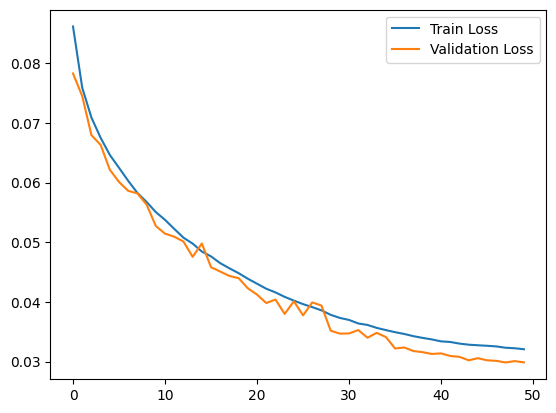

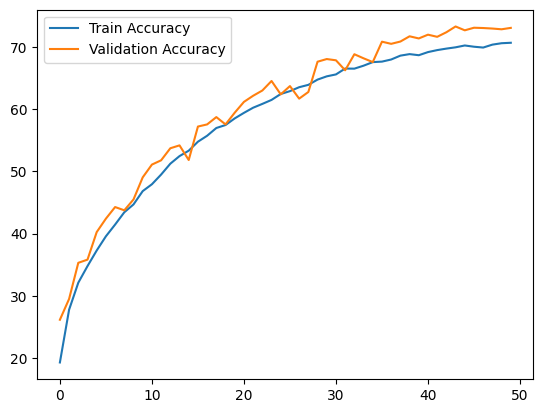

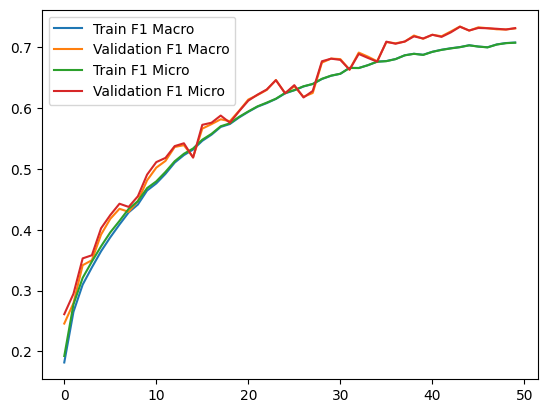

In [5]:
# Save the model 

def training():
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/val', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print("Train Data: ", len(train_dataset))
    print("Validation Data: ", len(val_dataset))

    net = final_resnet(3, r, n)

    net = net.to(device)
    print("Working on device: ", device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.0001, weight_decay=1e-4, momentum=0.9)
    # optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.00001)


    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_f1_macro = []
    val_f1_macro = []
    train_f1_micro = []
    val_f1_micro = []

    print("------------------------Training Started------------------------")
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for i, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        scheduler.step()
        train_loss.append(running_loss/total)
        train_accuracy.append((correct/total)*100)
        train_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        train_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        net.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_loss.append(running_loss/total)
        val_accuracy.append((correct/total)*100)
        val_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        val_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        print("Epoch: ", epoch, "Train Loss: ", train_loss[-1], "Train Accuracy: ", train_accuracy[-1], "Train F1 Macro: ", train_f1_macro[-1], "Train F1 Micro: ", train_f1_micro[-1])

        print("Epoch: ", epoch, "Validation Loss: ", val_loss[-1], "Validation Accuracy: ", val_accuracy[-1], "Validation F1 Macro: ", val_f1_macro[-1], "Validation F1 Micro: ", val_f1_micro[-1])

        print("---------------------------------------------------------------")

        with open('Part1_withoutaug', 'a') as f:
            f.write("Epoch: " + str(epoch) + " Train Loss: " + str(train_loss[-1]) + " Train Accuracy: " + str(train_accuracy[-1]) + " Train F1 Macro: " + str(train_f1_macro[-1]) + " Train F1 Micro: " + str(train_f1_micro[-1]) + "\n")
            f.write("Epoch: " + str(epoch) + " Validation Loss: " + str(val_loss[-1]) + " Validation Accuracy: " + str(val_accuracy[-1]) + " Validation F1 Macro: " + str(val_f1_macro[-1]) + " Validation F1 Micro: " + str(val_f1_micro[-1]) + "\n")
            f.write("---------------------------------------------------------------\n")

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(train_f1_macro, label='Train F1 Macro')
    plt.plot(val_f1_macro, label='Validation F1 Macro')
    plt.legend()

    plt.plot(train_f1_micro, label='Train F1 Micro')
    plt.plot(val_f1_micro, label='Validation F1 Micro')
    plt.legend()
    plt.show()

    torch.save(net.state_dict(), 'Part1_withoutaug.pth')
    
    
training()